# <span style="color:#800080;font-size:60px;"> DEEP LEARNING  </span>
 <span style="color:#1B3B6F;font-size:30px;"> IRENE EIROS FONSECA  </span>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision import models
import scipy

from tqdm import tqdm   # Muestra una barra de progreso del bucle for
from torch.optim.lr_scheduler import ExponentialLR


In [3]:
COLLAB = False
if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PATH_BASE = '/content/drive/MyDrive/Irene&Juan/TFG'
    #PATH_BASE = '/content/drive/MyDrive/Datasets'
else:
    PATH_BASE = './'
    #PATH_BASE = 'C:\\Users\\irene\\Desktop\\TFG'
print('Working Path:\t', PATH_BASE)

Working Path:	 ./


# <span style="color:#1C7293;font-size:20px;"> CUDA: Computing platform  </span>

En este bloque se selecciona los recursos de hardware del ordenador en funcion de si está disponible CUDA o no. Si está disponible se ejecuta sobre el procesador y la memoria de la tarjeta gráfica y si no, sobre la memoria RAM y la CPU. 
Esto nos ayuda a que sea mas veloz.

In [4]:
##### CUDA
def get_Device(device_type):
    
    cuda = torch.cuda.is_available()
    if (device_type == 'auto'):
        if (cuda):
            device = torch.device('cuda:0')
            torch.cuda.empty_cache()
        else:
            device = torch.device('cpu')
    
    if (device_type == 'cpu'):
        device = torch.device('cpu')
        
    if (device_type == 'cuda'):
        device = torch.device('cuda:0')
    if (device.type =='cuda'):
        try:
            subprocess.check_output('nvidia-smi')
            nvidia = True
        except Exception: # this command not being found can raise quite a few different errors depending on the configuration
            nvidia = False    
    else:
        nvidia = False    

    return device

cuda = torch.cuda.is_available() 
if cuda:
    device = get_Device('cuda')
else:
    device = get_Device('cpu')

print('Cuda Available:', cuda)
print('Selected Device:', device)


Cuda Available: True
Selected Device: cuda:0


## A. PREPARACION DE LOS DATOS


**1. Obtenemos los Datos a partir de los archivos en disco**

---
En este bloque se selecciona la base de datos y sus caracteristicas principales: canales y clases y el path donde se encuentran los datos. 


In [5]:
# DATA SOURCE PARAMETERS 
SOURCE           = 'KAGGLE'
SAMPLE_FREQUENCY = 1000      # SAMPLE FREQUENCY
if SOURCE == 'IRENE':
    CLASES           = 4         # Categories 
    CHANNELS         = 1         
if SOURCE == 'KAGGLE':
    CLASES           = 6         # Categories 
    CHANNELS         = 8
    
SAMPLE_MAXDATA   = 8000   

if(SOURCE == 'KAGGLE'):
    PATH_DATA = os.path.join(PATH_BASE, "DATOS_KAGGLE" )    

if(SOURCE == 'IRENE'):
    PATH_DATA = os.path.join(PATH_BASE, "DATOS_EMG" )    
print(PATH_DATA)

./DATOS_KAGGLE


Los datos originales están almacenados de forma distinta en Kaggle (todos los datos en un unico archivo CSV) y en la custom database(se trata de una captura de 10 segundos y se almacena de forma independiente).

Cada rutina lo hace de forma independiente, una para cada database. Se leen todos los archivos y se generan archivos binarios con extension "npy"(uno para cada clase). 

Por tanto, cada script se puede ejecutar sea cual sea la base de datos origen.



Se puede elegir qué base de datos queremos elegir... "Irene" se refiere a mi "custom data" 

In [5]:
if(SOURCE == 'KAGGLE'):
        Fs = 1000
        filename = "EMG-dataKaggle.csv"
        path_file = os.path.join(PATH_DATA, filename)
        print(path_file)
        df = pd.read_csv(path_file)
        print(df.info())
        print(df.head())

        print("\nclass :", df["class"].unique(),"\n")
        print("Labels :",df["label"].unique()) # 36 people hand gesture data
        print("\nValue Count :\n",df["class"].value_counts())

        df.drop('time', inplace=True, axis=1)
        df = df[df['class'] != 0] #se quita, ruido vacio, diferentes del resto, afecta a la clasificacion
        df = df[df['class'] != 7] #tiene pocas muestras así que mejor quitarla

        data_clases = df.groupby(['class']) #agrupas

        data_list = []
        for n in range(CLASES):
            data_list.append([])

        # Iterar sobre los grupos
        for ix, (nombre_classe, classe) in enumerate(data_clases):
            print('\nCLASE: ',ix, '-', nombre_classe, '\n')
            data_labels = classe.groupby(['label'])

            for iy, (nombre_label, label) in enumerate(data_labels):
                sample = label.values
                sample_length = len(sample)
                sample_shape = sample.shape
                if(len(sample) > SAMPLE_MAXDATA):
                    sample = sample[:SAMPLE_MAXDATA,:CHANNELS]#segunda columna: canales

                if(len(sample) < SAMPLE_MAXDATA):
                    repeat = np.tile(sample,(SAMPLE_MAXDATA//len(sample) + 1, 1))
                    sample = repeat[:SAMPLE_MAXDATA,:CHANNELS]
                        
                sample = np.transpose(sample, axes=(1,0)) #muevo canales a la primera columna
                print('SAMPLE:', iy,sample_shape,'--->', sample.shape)
                data_list[ix].append(sample)
                
            filename_category = ''.join(['EMG_Gesture_',str(ix),'.npy'])
            path_category = os.path.join(PATH_DATA, filename_category)
            np.save(path_category, np.stack(data_list[ix]))

       

./DATOS_KAGGLE\EMG-dataKaggle.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4237907 entries, 0 to 4237906
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   time      int64  
 1   channel1  float64
 2   channel2  float64
 3   channel3  float64
 4   channel4  float64
 5   channel5  float64
 6   channel6  float64
 7   channel7  float64
 8   channel8  float64
 9   class     int64  
 10  label     int64  
dtypes: float64(8), int64(3)
memory usage: 355.7 MB
None
   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0     1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1     5   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2     6  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3     7  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4     8  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel

ARCHIVOS DE MI PROPIO SISTEMA

In [6]:
if(SOURCE == 'IRENE'):
        index_pos = 10 #posicion dentro del prefijo que indica la categoria donde estoy
        prefix = 'datos_emg_'

        data_list = []

        file_iter = os.listdir(PATH_DATA)
        file_path = [ file for file in file_iter if file.startswith(prefix)  ]
        for n in range(CLASES):
            data_list.append([])


        for file in file_path:
            clase = int(file[index_pos])
            path_file = os.path.join(PATH_DATA, file)
            print(path_file)
            sample = np.genfromtxt(path_file, delimiter = ",")
            sample = np.expand_dims(sample, axis=1)
            
            if(len(sample) > SAMPLE_MAXDATA):
                    sample = sample[:SAMPLE_MAXDATA,:]#segunda columna: canales

            if(len(sample) < SAMPLE_MAXDATA):
                repeat = np.tile(sample,(SAMPLE_MAXDATA//len(sample) + 1, 1))
                sample = repeat[:SAMPLE_MAXDATA]
                    
            sample = np.transpose(sample, (1,0))
            data_list[clase].append(sample)


CLASS: 0 --> ./DATOS_KAGGLE\emg_gesture_0.npy 
	LENGTH:	 (36, 1, 8000)
CLASS: 1 --> ./DATOS_KAGGLE\emg_gesture_1.npy 
	LENGTH:	 (36, 1, 8000)
CLASS: 2 --> ./DATOS_KAGGLE\emg_gesture_2.npy 
	LENGTH:	 (36, 1, 8000)
CLASS: 3 --> ./DATOS_KAGGLE\emg_gesture_3.npy 
	LENGTH:	 (36, 1, 8000)
CLASS: 4 --> ./DATOS_KAGGLE\emg_gesture_4.npy 
	LENGTH:	 (36, 1, 8000)
CLASS: 5 --> ./DATOS_KAGGLE\emg_gesture_5.npy 
	LENGTH:	 (36, 1, 8000)

SAMPLE 0 - CLASSS 0


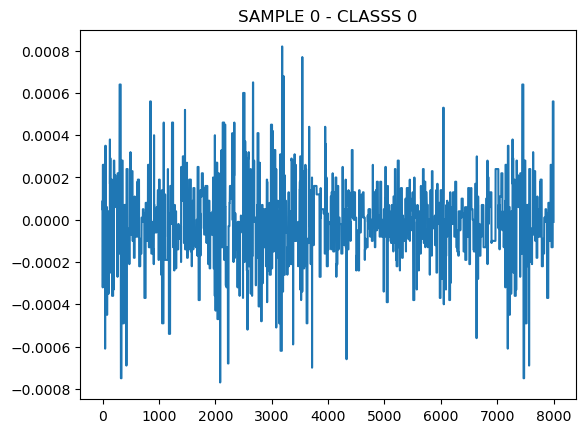

In [7]:
# TESTEA LOS ARCHIVOS DE LA BASE DE DATOS
#Guarda  y carga archivos para cada clase
for idx in range(CLASES):
    file = ''.join(['emg_gesture_',str(idx),'.npy'])
    path_file = os.path.join(PATH_DATA, file)
    sample = np.stack(data_list[idx])
    np.save(path_file, sample)
    sample = np.load(path_file)
    print('CLASS:',idx,'-->',path_file,'\n\tLENGTH:\t', sample.shape)



# Visualizar el contenido de la muestra 0 de la categoria 0

print('\nSAMPLE 0 - CLASSS 0')
for channel in range(CHANNELS):
    plt.plot(sample[0,channel])  # cmap es el mapa de colores que quieres usar
plt.title('SAMPLE 0 - CLASSS 0')
plt.show()


if CHANNELS > 1:
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    axs[2, 2].axis('off')

    for channel in range(CHANNELS):
        fila = channel // 3
        columna = channel % 3
        ax = axs[fila, columna]
        ax.plot(sample[0,channel])
        ax.set_title(f'Channel {channel+1}')
    
    plt.suptitle('SAMPLE 0 - CLASSS 0')
    
    # Ajustar automáticamente el diseño para evitar superposiciones
    plt.tight_layout()
    
    # Mostrar los gráficos
    plt.show()



Se leen los archivos de datos binarios con extension "npy" y se forma la siguiente estructura de datos de 4 dimensiones, el cual se utiliza en el resto del script: 

EMG_DataFiles : CLASE x SAMPLE x CHANNEL x DATA


In [8]:
#Datos EMG se almacenan en una lista para cada clase
EMG_DataFiles = []

for clase in range(CLASES):
    file = "".join(["EMG_Gesture_", str(clase), ".npy"])
    pathfile = os.path.join(PATH_DATA, file)
    EMG_DataFiles.append(np.load(pathfile))

    print("\nDatos obtenidos de la categoria numero", clase, ":", len(EMG_DataFiles[clase]))
    print("Tamaño de las muestras", EMG_DataFiles[clase][0].shape)
    print("Valor max", np.max(EMG_DataFiles[clase]), "min", np.min(EMG_DataFiles[clase]) )



Datos obtenidos de la categoria numero 0 : 36
Tamaño de las muestras (1, 8000)
Valor max 0.00016 min -0.00023

Datos obtenidos de la categoria numero 1 : 36
Tamaño de las muestras (1, 8000)
Valor max 0.00127 min -0.00128

Datos obtenidos de la categoria numero 2 : 36
Tamaño de las muestras (1, 8000)
Valor max 0.00127 min -0.00128

Datos obtenidos de la categoria numero 3 : 36
Tamaño de las muestras (1, 8000)
Valor max 0.00074 min -0.00079

Datos obtenidos de la categoria numero 4 : 36
Tamaño de las muestras (1, 8000)
Valor max 0.00127 min -0.00128

Datos obtenidos de la categoria numero 5 : 36
Tamaño de las muestras (1, 8000)
Valor max 0.00127 min -0.00128


CLASE 0 SAMPLE 0


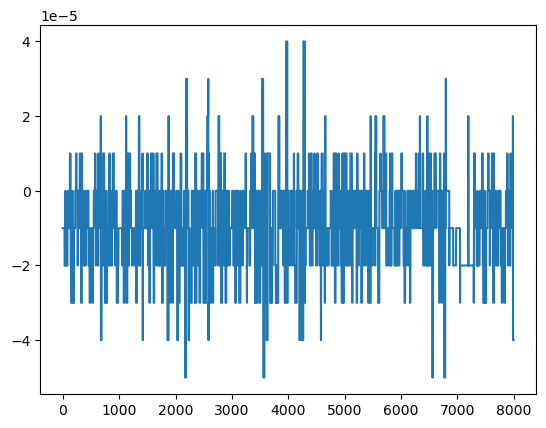

CLASE 1 SAMPLE 0


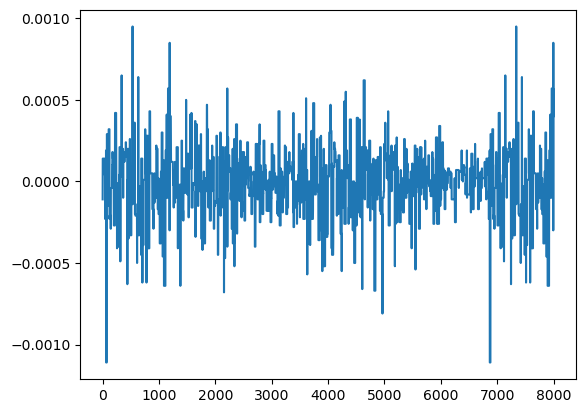

CLASE 2 SAMPLE 0


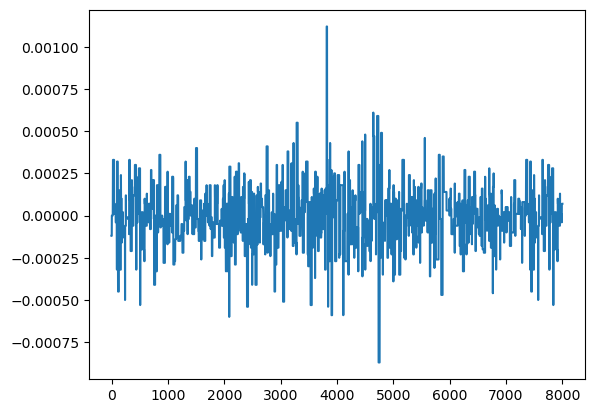

CLASE 3 SAMPLE 0


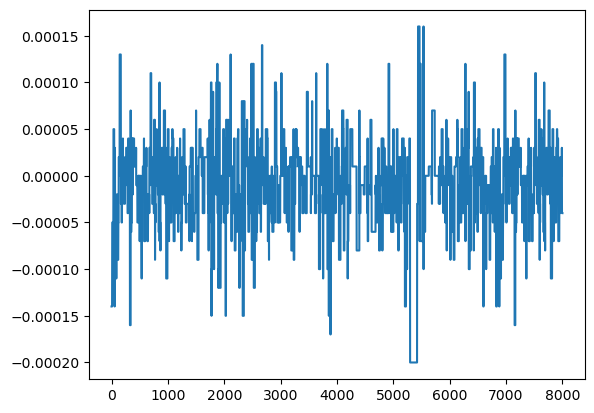

CLASE 4 SAMPLE 0


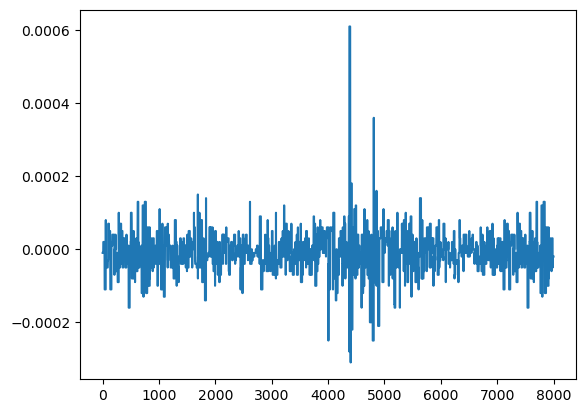

CLASE 5 SAMPLE 0


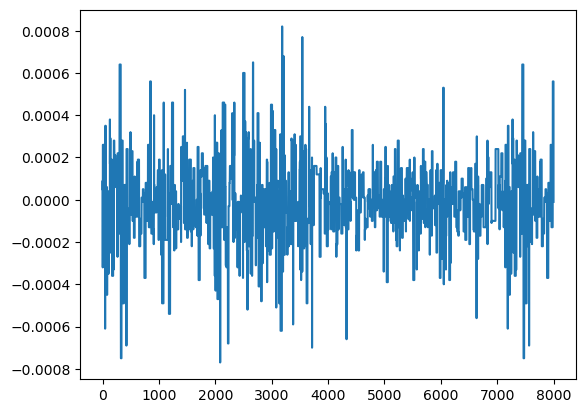

In [9]:
#Se itera sobre cada clase y una sample especifica. En este caso, se hace el plot del canal 1 
for clase in range(CLASES):
        sample = 0
    #for sample in range(len(EMG_DataFiles[clase])):
        print('CLASE', clase, 'SAMPLE', sample)
        plt.plot(EMG_DataFiles[clase][sample][0])
        plt.show()



In [10]:
#Filtro pasabanda para cada clase y rectificacion
#Se selecciona si se utiliza

FILTER = False

if FILTER:
    for clase in range(CLASES):
        for sample in range(len(EMG_DataFiles[clase])):
             for channel in range(len(EMG_DataFiles[clase][sample])):
                 b, a = scipy.signal.butter(4, [20, 450], btype='bandpass', fs=SAMPLE_FREQUENCY)
                 filtered_emg = scipy.signal.filtfilt(b, a, EMG_DataFiles[clase][sample][channel])
        
                 # Rectification
                 rectified_emg = np.abs(filtered_emg)
                 EMG_DataFiles[clase][sample][channel] = rectified_emg

        print("\nCLASE", clase, "\n\tNúmero de Archivos:", len(EMG_DataFiles[clase]))
        print("\tEstructura de los datos:\t", EMG_DataFiles[clase][0].shape)
        print("\t Máximo:\t", np.max(EMG_DataFiles[clase]), "\tMinimo:\t", np.min(EMG_DataFiles[clase])) 
        print("\t Media: \t", np.mean(EMG_DataFiles[clase]), "\tStd.:  \t", np.std(EMG_DataFiles[clase])) 
        print("\t Zeros: \t", np.sum(np.isnan(EMG_DataFiles[clase])), "\tInfinite:\t", np.sum(np.isinf(EMG_DataFiles[clase]))) 

**2. Construimos las listas Globales** 

---
Es el conjunto de Todas las muestras y debe incluir:


- Una única lista para el conjunto de todos las muestras de todas las categorias juntas
- Un Array para el target con el valor de la categoría en la misma posición que ocupa cada muestra en la primera matriz


**SLIDE WINDOW:** Se segmentan los datos EMG en samples de tamaño "Sample_Size" con un desplazamiento "Stride". Estas muestras se almacenan en la lista "X" y la clase de cada muestra en la lista "Y". 

Tamaño de las listas GLOBALES de muestras:	DATOS:	 56592 	TARGET (Y):	 56592
	Tamaño de cada muestra de DATOS:	 (1, 150)
	TARGET(clase/gesto) de la muestra 0     :	 0 
	 (NOTA: Los escalares, los números individuales, tienen tamaño 0, es decir shape = () )


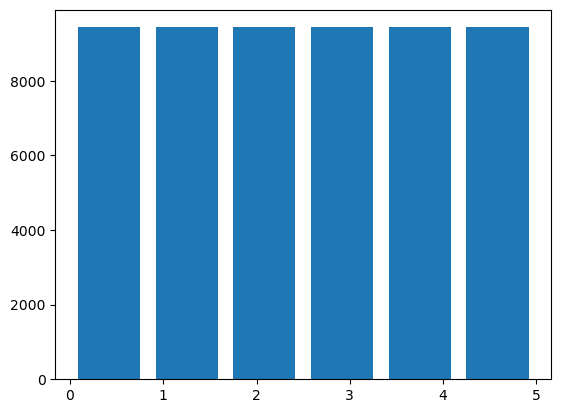

In [11]:
X = []
Y = []
SAMPLE_CHANNELS = EMG_DataFiles[0][0].shape[0]
SAMPLE_DATA     = EMG_DataFiles[0][0].shape[1]
SAMPLE_SIZE     = 150   #tamaño muestras finales
STRIDE          = 30    #desplazamiento dentro del archivo de datos

for clase in range(CLASES):
    for sample in EMG_DataFiles[clase]:
        for iz in range(0, SAMPLE_DATA - SAMPLE_SIZE + 1, STRIDE):
            X.append(sample[:,iz:iz+SAMPLE_SIZE])
            Y.append(clase)

#target me indica el indice
print('Tamaño de las listas GLOBALES de muestras:\tDATOS:\t', len(X) ,'\tTARGET (Y):\t',len(Y))
print('\tTamaño de cada muestra de DATOS:\t', X[0].shape)
print('\tTARGET(clase/gesto) de la muestra 0     :\t', Y[0], '\n\t (NOTA: Los escalares, los números individuales, tienen tamaño 0, es decir shape = () )')
plt.hist(Y, bins = CLASES, rwidth = 0.8)
plt.show()


In [12]:
# PESOS DE PONDERACION DE LAS CLASES
#Se hace para balancear el numero de muestras en el entrenamiento del modelo
if SOURCE == 'KAGGLE':
    class_counts = [1,1,1,1,1,1] #proporcion de archivos entre categorias 36*6/36    
else:
    class_counts = [8, 6, 5,6] #archivos para cada categoria: 25/8
total_samples = sum(class_counts)
class_weights = [total_samples/class_count for class_count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print('Class Weights:', class_weights)

Class Weights: tensor([6., 6., 6., 6., 6., 6.], device='cuda:0')


**3. Transformación y preparación de los datos**

---
Normalizamos los datos para que todos los valores estén en un rango determinando y controlado, para ello hay varias opciones:


*   Valores en el rango [0,1]. Si queremos que todos los valores se encuentren en este rango aplicamos la transformación

        X =  ( X - X_min)/ (X_max - X_min)

*   Media = 0 y Desviación Estándar = 1. Este tipo de normalización es la más habitual en machine learning, ya que los datos de entradas estarán todos en torno al valor (positivos y negativos) y se distribuyen con una desviación estándar igual a 1...es decir, la mayoría de los datos estárán entre -1 y 1, aunque unos pocos tomarán valores más extremos. En general, resulta mas eficiente en el entrenamiento de la máquina:

        X =  (X - X_mean)/X_std

Está transformación hay que aplicarla por igual a todos los datos que se vayan a usar tanto en la fase de entrenamiento como en la de testeo como cuando se utilice finalmente para realizar predicciones sobre datos de categorias desconocidas

*En este caso, utilizo esta segunda opción de media = 0 y std = 1.  *


In [13]:
X_min = np.min(X)
X_max = np.max(X)
X_mean = np.mean(X)
X_std = np.std(X)
print('Valores estadísticos ANTES de la normalización:')
print('\t Min = ',X_min,'\t Max = ',X_max,'\t Mean = ',X_mean,'\t STD = ',X_std)

X = (X-X_mean)/X_std

print('\nValores estadísticos DESPUES de la normalización:')
print('\t Min = ',np.min(X),'\t Max = ',np.max(X),'\t Mean = ',np.mean(X),'\t STD = ',np.std(X))
print('\nNOTA: Cuando se utilizan los valores no cambian porque ya estaban normalizados de origen... \n',
'Inicialmente ya tinene una media que es practicametne cero y una desviacion estandar de 1')


Valores estadísticos ANTES de la normalización:
	 Min =  -0.00128 	 Max =  0.00127 	 Mean =  -8.110495005183304e-06 	 STD =  0.00019071553099195857

Valores estadísticos DESPUES de la normalización:
	 Min =  -6.669040000986839 	 Max =  6.70165921127354 	 Mean =  1.3460368643104056e-17 	 STD =  0.9999999999999989

NOTA: Cuando se utilizan los valores no cambian porque ya estaban normalizados de origen... 
 Inicialmente ya tinene una media que es practicametne cero y una desviacion estandar de 1


**4. Creamos los conjuntos de entrenamiento y testeo**

---


Se puede hacer de varias maneras pero la más cómoda es utilizar la función *split* indicando la fracción que queremos reservar para realizar el testeo final.

Se reserva de forma aleatoria un espacio para entrenar y otro para hacer el test, con el fin de entrenar la máquina con datos que no he entrenado.

In [14]:
test_size = 0.15    # RESERVAMOS el 15 % para el testeo final
                    # Estos datos no se usarán nunca durante el entrenamiento de la máquina
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)

print('Tamaño de las Listas:')
print('\tDatos de Entrenamiento:\t', len(X_train), 'muestras de tamaño', X_train[0].shape)
print('\tDatos de Entrenamiento:\t', len(X_test), 'muestras de tamaño', X_test[0].shape)


Tamaño de las Listas:
	Datos de Entrenamiento:	 48103 muestras de tamaño (1, 150)
	Datos de Entrenamiento:	 8489 muestras de tamaño (1, 150)


**5. Construimos el Dataset**

---



*   **Dataset**. Es una clase específica para organizar y manejar los datos junto con sus targets sin que corramos el riesgo de que se desordenen
Basicamente su función es almacenar las dos listas X e Y de cada conjunto (entrenamiento y test) y cuando le pidan una muestra determinada (con el metodo gettitem) devolver una muestra y un target concreto para el índice que le pidan



In [15]:
#self: indica la propia clase, __init__:es el constructor
#cuando heredo de dataset es obligatorio tener __len__ y __getitem__ . Las dos barras sifingica que no te las inventas, vienen ya definididas
class EMGDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self): #devuelve la longitud, numero de datos del dataset
        return len(self.X)

    def __getitem__(self, idx): #devuelve el item numero que sea

        x = self.X[idx]
        y = self.Y[idx]
        return x, y

train_dataset = EMGDataset(X_train, Y_train)
test_dataset = EMGDataset(X_test, Y_test)
print('Tamaño de los Datasets:')
print('\tDataset de Entrenamiento:\t', len(train_dataset))
print('\tDataset de Test         :\t', len(test_dataset))

print('\nTesteo de los Datasets:')
print('\tPedimos un dato y vemos la forma del dato y el valor del target:')

dato_train,  target_train = next(iter(train_dataset))
dato_test,  target_test = next(iter(test_dataset))

print('\tTamaño del Dato de Entrenamiento :\t', list(dato_train.shape), '\ttarget = ', target_train)
print('\tTamaño del Dato de Test          :\t', list(dato_test.shape), '\ttarget = ', target_test)

#dato = train_dataset.__getitem__(7)
#print(dato)


Tamaño de los Datasets:
	Dataset de Entrenamiento:	 48103
	Dataset de Test         :	 8489

Testeo de los Datasets:
	Pedimos un dato y vemos la forma del dato y el valor del target:
	Tamaño del Dato de Entrenamiento :	 [1, 150] 	target =  4
	Tamaño del Dato de Test          :	 [1, 150] 	target =  4


## B. PARÁMETROS E HIPERPARÁMETROS

**2. Parámetros y funciones del Entrenamiento**

---



*   EPOCHS. Relacionado con el numero de veces que se va a repetir el entrenamiento.
*   BATCH_SIZE. Muestras cada vez que se procesan los pesos 
*   LEARNING_RATE. Cómo se estimaa
*   CRITERION. Error cometido entre el label y el target.
*   DATALOADER. Este objeto se encarga de utilizar el dataset e ir sirviendo los datos a la máquina a partir de este. Cada vez que se le piden datos devuelve un número de muestras dado por el parámetro BATCH_SIZE. Es el que realiza la función de aleatorizar los datos, ya que es importante en que cada conjunto esté formado por muestras aleatorias de todas las categorias
*   NETWORK. Modelo de red utilizado 
   







In [16]:
EPOCHS = 100            # Número de veces que se va a repetir el proceso de entrenamiento
BATCH_SIZE  = 16           # Número de muestras procesadas cada vez que se actualizan los pesos
#al dataset de entrenamiento le paso 8 y cada 8 pasos hay ajuste de pesos. lo repito el numero de epocas que me dice

LEARNING_RATE  = 0.15 # Parámetro de aprendizaje aplicado en cada batch. los modifico poco a poco, el aprendizaje es lento
DROPOUT        = 0.0     # 0.0 Indica que no lo usas
CRITERION = nn.CrossEntropyLoss(weight=class_weights)  # MSELoss, CrossEntropyLoss
NETWORK = 'PRETRAINED'   #modelo de red utilizado
 # Función de Pérdidas.. Calcula el error cometido entre
                            # las predicciones de la máquina (LABEL) y las
                            # categorias realies (TARGET)
#DataLoader: me pide los datos de batch_size en bat_size
train_loader =  DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader =   DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

print('\nTesteo de los Dataloader:')
print('\tPedimos un BATCH de datos y vemos la forma de los datos y los valores del target:')
print('\tEsperamos que el batch tenga tamaño = BATCH_SIZE x INPUT_CHANNELS')

dato_train,  target_train = next(iter(train_loader))
dato_test,  target_test = next(iter(test_loader))

print('\n\tTamaño del BATCH de datos de Entrenamiento :\t', list(dato_train.shape))
print('\ttarget de las muestras = ', target_train)
print('\n\tTamaño del BATCH de datos de Test: \t', list(dato_test.shape))
print('\ttarget de las muestras = ', target_test)



Testeo de los Dataloader:
	Pedimos un BATCH de datos y vemos la forma de los datos y los valores del target:
	Esperamos que el batch tenga tamaño = BATCH_SIZE x INPUT_CHANNELS

	Tamaño del BATCH de datos de Entrenamiento :	 [16, 1, 150]
	target de las muestras =  tensor([1, 2, 4, 5, 2, 1, 4, 1, 0, 4, 5, 4, 3, 4, 1, 2])

	Tamaño del BATCH de datos de Test: 	 [16, 1, 150]
	target de las muestras =  tensor([2, 0, 1, 5, 3, 5, 0, 5, 0, 4, 4, 1, 1, 5, 0, 5])


**C. MODELO DE RED**

**1. Clase con la definicion del modelo**

---



In [17]:
#  PYTORCH: CNN 
#  IMAGENES de 256 x 256 pixeels RGB  (3 canales)
class ConvImageNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvImageNet, self).__init__() #super:heredo de Module

#añadir capa dropout
        #Capa 1
        #  INPUT SHAPE = (CHANNELS, HEIGHT, WIDTH)
        self.capa1 =  nn.Conv2d(in_channels, 16, kernel_size = (3,4), padding = (1,1), stride = (1,2))
        self.drop1 =  nn.Dropout(DROPOUT) #para ralentizar el aprendizaje
        self.norm1 =  nn.BatchNorm2d(16)
        self.activa1 = nn.ReLU()  # Tanh, Sigmoid, ReLU()

        #Capa 2
        self.capa2 =  nn.Conv2d(16, 32, kernel_size = (3,4), padding = (1,1), stride = (1,2))
        self.drop2 =  nn.Dropout(DROPOUT)
        self.norm2 =  nn.BatchNorm2d(32)
        self.activa2 = nn.ReLU()

        #Capa 3
        self.capa3 =  nn.Conv2d(32, 64, kernel_size = (3,4), padding = (1,1), stride = (1,2))
        self.drop3 =  nn.Dropout(DROPOUT)
        self.norm3 =  nn.BatchNorm2d(64)
        self.activa3 = nn.ReLU()

        #Capa 4
        self.capa4 =  nn.Conv2d(64, 128, kernel_size = (3,4), padding = (1,1), stride = (1,2))
        self.drop4 =  nn.Dropout(DROPOUT)
        self.norm4 =  nn.BatchNorm2d(128)
        self.activa4 = nn.ReLU()

        #Capa 5

        n_convlayers = 4   # Número de capas convolutinvas
        reduction_dim2 = int(SAMPLE_SIZE/2**n_convlayers) # Tamaño de la Dimension 2 debido al stride=2
        n_kernels = 128 # Kernels de la última capa convolutiva
        n_channels = SAMPLE_CHANNELS
        output_size = reduction_dim2 * n_kernels * n_channels
        self.capa5 =  nn.Linear(output_size, 256)
        self.drop5 =  nn.Dropout(DROPOUT)
        self.norm5 =  nn.BatchNorm1d(256)
        self.activa5 = nn.ReLU()

        # out_channels = Número de Categorias: 6 (Número de movimientos a detectar)
        self.capa6 =  nn.Linear(256, out_channels)
        self.activacion =nn.Softmax(dim = 1)



    def forward(self, x):
       #  X.shape =  [3, 256, 256]
       #print(x.shape)
       x = x.reshape(x.shape[0],1,x.shape[1], x.shape[2])
       #print(x.shape)
       #Capa 1
       y = self.capa1(x)
       x = self.drop1(y)
       x = self.norm1(x) #para normalizar los datos
       x = self.activa1(x) #despues de normalizar le paso la activacion
       #Capa 2
       #print(x.shape)
       x = self.capa2(x)
       x = self.drop2(x)
       x = self.norm2(x)
       x = self.activa2(x)
       #Capa 3
       #print(x.shape)
       x = self.capa3(x)
       x = self.drop3(x)
       x = self.norm3(x)
       x = self.activa3(x)
       #Capa 4
       #print('4',x.shape)
       x = self.capa4(x)
       x = self.drop4(x)
       x = self.norm4(x)
       x = self.activa4(x)
       #Capa 5
       #print('5',x.shape)
       x = x.reshape(x.shape[0],x.shape[1]* x.shape[2]*x.shape[3])
       x = self.capa5(x)
       x = self.drop5(x)
       x = self.norm5(x)
       x = self.activa5(x)
       #Capa 6
       x = self.capa6(x)
       x = self.activacion(x)
       return x


In [18]:
#  PYTORCH
class ConvEMGNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvEMGNet, self).__init__() #super:heredo de Module

#añadir capa dropout
        #Capa 1
        # in_channels = 1  Por que tenemos una única serie temporal de 600 datos (CASO BREATHING)
        self.capa1 =  nn.Conv1d(in_channels, 16, kernel = 4, padding = 2, stride = 2)
        self.drop1 =  nn.Dropout(0.4) #para ralentizar el aprendizaje
        self.norm1 =  nn.BatchNorm1d(4096)
        self.activa1 = nn.ReLU()
        #Capa 2
        self.capa2 =  nn.Conv1d(16, 32, kernel = 4, padding = 2, stride = 2)
        self.drop2 =  nn.Dropout(0.4)
        self.norm2 =  nn.BatchNorm1d(4096)
        self.activa2 = nn.ReLU()
        #Capa 3
        self.capa3 =  nn.Conv1d(32, 64, kernel = 4, padding = 2, stride = 2)
        self.drop3 =  nn.Dropout(0.4)
        self.norm3 =  nn.BatchNorm1d(4096)
        self.activa3 = nn.ReLU()
        #Capa 4
        self.capa4 =  nn.Conv1d(64, 128, kernel = 4, padding = 2, stride = 2)
        self.drop4 =  nn.Dropout(0.4)
        self.norm4 =  nn.BatchNorm1d(4096)
        self.activa4 = nn.ReLU()
        #Capa 5
        # out_channels = Número de Categorias: 2  (Breathing y NonBreathing)
        self.capa5 =  nn.Linear(128 * 36, out_channels)

        self.activacion =nn.Sigmoid()

    def forward(self, x):
       #  X.shape =  [600]
       x.reshape[1, x.shape[0]]

       #  X.shape =  [1, 600]
       #Capa 1
       x = self.capa1(x)
       x = self.drop1(x)
       x = self.norm1(x) #para normalizar los datos
       x = self.activa1(x) #despues de normalizar le paso la activacion
       #Capa 2
       x = self.capa2(x)
       x = self.drop2(x)
       x = self.norm2(x)
       x = self.activa2(x)
       #Capa 3
       x = self.capa3(x)
       x = self.drop3(x)
       x = self.norm3(x)
       x = self.activa3(x)
       #Capa 4
       x = self.capa4(x)
       x = self.drop4(x)
       x = self.norm4(x)
       x = self.activa4(x)
       #Capa 5
       x = self.capa5(x)
       x = self.activacion(x)
       return x


In [19]:
#TRANSFER LEARNING

class ConvPretrained(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvPretrained, self).__init__() #super:heredo de Module

        self.capa1 =  nn.Conv2d(in_channels, 3, kernel_size = (3,4), padding = (1,1))
        self.pretrained = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)  #modelos distintos como resnet150, Googlenet
        for param in self.pretrained.parameters():
            param.require_grad = False
        in_features = self.pretrained.fc.in_features
        self.pretrained.fc = nn.Linear(in_features, 256)
        self.drop1 =  nn.Dropout(DROPOUT)
        self.norm1 =  nn.BatchNorm1d(256)
        self.activa1 = nn.Tanh()

        # out_channels = Número de Categorias: 6 (Número de movimientos a detectar)
        self.capa2 =  nn.Linear(256, out_channels)
        self.activacion =nn.Softmax(dim = 1)


    def forward(self, x):
      #print(x.shape)
      x = x.reshape(x.shape[0],1,x.shape[1], x.shape[2])
      #print(x.shape)
      x = self.capa1(x)
      x = self.pretrained(x)
      #print(x.shape)
      x = self.drop1(x)
      x = self.norm1(x) #para normalizar los datos
      x = self.activa1(x) #despues de normalizar le paso la activacion
      #Capa Dense de Salida
      x = self.capa2(x)
      #print(x.shape)
      x = self.activacion(x)
      #print(x.shape)
      return x


#añadir capa dropout

In [20]:
#RED DE TIPO DENSE
class SimpleNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleNet, self).__init__() #super:heredo de Module

#añadir capa dropout
        #Capa 1
        self.capa1 =  nn.Linear(in_channels, 4096)
        self.drop1 =  nn.Dropout(0.4) #para ralentizar el aprendizaje
        self.norm1 =  nn.BatchNorm1d(4096)
        self.activa1 = nn.ReLU()
        #Capa 2
        self.capa2 =  nn.Linear(4096, 2048)
        self.drop2 =  nn.Dropout(0.4)
        self.norm2 =  nn.BatchNorm1d(2048)
        self.activa2 = nn.ReLU()
        #Capa 3
        self.capa3 =  nn.Linear(2048, 512)
        self.drop3 =  nn.Dropout(0.4)
        self.norm3 =  nn.BatchNorm1d(512)
        self.activa3 = nn.ReLU()
        #Capa 4
        self.capa4 =  nn.Linear(512,64)
        self.drop4 =  nn.Dropout(0.4)
        self.norm4 =  nn.BatchNorm1d(64)
        self.activa4 = nn.ReLU()
        #Capa 5
        self.capa5 =  nn.Linear(64, out_channels)

        self.activacion =nn.Softmax(dim = 1)


    def forward(self, x):
      #redimensionamiento de los datos
       #print('----')
       #print('1', x.shape)
       x = x.reshape(x.shape[0], -1)
       #Capa 1
       x = self.capa1(x)
       x = self.drop1(x)
       x = self.norm1(x) #para normalizar los datos
       x = self.activa1(x) #despues de normalizar le paso la activacion
       #Capa 2
       #print('2', x.shape)
       x = self.capa2(x)
       x = self.drop2(x)
       x = self.norm2(x)
       x = self.activa2(x)
       #Capa 3
       #print('3', x.shape)
       x = self.capa3(x)
       x = self.drop3(x)
       x = self.norm3(x)
       x = self.activa3(x)
       #Capa 4
       #print('4', x.shape)
       x = self.capa4(x)
       x = self.drop4(x)
       x = self.norm4(x)
       x = self.activa4(x)
       #Capa 5
       #print('5', x.shape)

       x = self.capa5(x)
       x = self.activacion(x)
       return x

In [21]:
#Elijo qué red voy a utilizar
def get_Model(NETWORK):
    if NETWORK == 'DENSE':
        INPUT_CHANNELS = X.shape[1]*X.shape[2]
        model =  SimpleNet(INPUT_CHANNELS, CLASES)
    if NETWORK == 'CNN_Image':
        INPUT_CHANNELS = 1
        model =  ConvImageNet(INPUT_CHANNELS, CLASES)
    if NETWORK == 'PRETRAINED':
        INPUT_CHANNELS = 1
        model =  ConvPretrained(INPUT_CHANNELS, CLASES)
    return model

model = get_Model(NETWORK)
print('ARQUITECTURA DEL MODELO:\n')
print(model)

ARQUITECTURA DEL MODELO:

ConvPretrained(
  (capa1): Conv2d(1, 3, kernel_size=(3, 4), stride=(1, 1), padding=(1, 1))
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=

**2. Optimizador**

In [22]:
#optimizar los parámetros con "SGD". Que se le pasa? PArametros del modelo(los millones de pesos y el learning rate)
#  SGD, Adam
optimizer = optim.SGD(model.parameters(), lr = LEARNING_RATE)


In [23]:
# GUARDAR LOS PESOS DE MAQUINA
def saveModel(model, optimizer, name):
    checkpoint = {
        'optimizer' :  None,
        'model'     :  None
    }
    
    checkpoint['optimizer'] =  optimizer.state_dict()
    checkpoint['model']     =  model.state_dict()
    
    path_model = os.path.join(PATH_DATA, name)
    print('SAVE MODEL PATH:',path_model)
    torch.save(checkpoint, path_model)
    
    path_model_script = os.path.join(PATH_DATA, "model_script.pt") 
    #exportacion para android para utilizar el modelo con torch script
    scripted_model = torch.jit.script(model) 
    scripted_model.save(path_model_script)
        
    metadata = {
        "input_size": [1, 1, 150], 
        "output_classes": ["REPOSO", "ARRIBA", "ABAJO", "CERRADO"],
        "model_name": "ResNet50",
        "hyperparameters": {
            "learning_rate": 0.005,
            "epochs": 50
        }
    }
    
    # Guardar la configuración en un archivo JSON
    with open("model_metadata.json", "w") as json_file:
        json.dump(metadata, json_file)

In [24]:
# CARGAR LOS PESOS DE MAQUINA
def load_Model(model, model_name):
    path_model = os.path.join(PATH_DATA, model_name)
    print(path_model)
    checkpoint = torch.load(path_model)
    model.load_state_dict(checkpoint['model'])
    return model

**2.1 Checkpoint**

Se utiliza para guardar el estado del modelo y el optimizador durante el entrenamiento. Esto permite reanudar el entrenamiento desde ese punto en caso de interrupciones o para evaluar el modelo en las diferentes etapas. 

El checkpoint se activa si el valor actual mejora respecto al minimo y guarda el modelo y el optimizador en un archivo llamado "checkpoint.pt". 

In [25]:
CALLBACK_CHECKPOINT = True
monitor = []
def checkpoint(epoch, value):
    print(value, np.min(monitor))
    if value <= np.min(monitor):
        print('CHECKPOINT ACTIVATED')
        saveModel(model, optimizer, 'checkpoint.pt')

**2.2 Learning Rate Callback**

Si está activado, permite configurar un "scheduler" para ajustar la tasa de aprendizaje(learning rate) durante el entrenamiento.

Se guarda el learning rate inicial, se crea un scheduler de tasa de aprendizaje exponencial (Exponential_LR) con un factor de decaimiento (gamma) de 0.85, que reduce el learning rate exponencialmente en cada EPOCH, comenzando desde el EPOCH 20.


In [26]:
CALLBACK_LEARNING_RATE = False
if CALLBACK_LEARNING_RATE:
    for param_group in optimizer.param_groups:
        if 'initial_lr' not in param_group:
            param_group['initial_lr'] = param_group['lr']
    lr_scheduler = ExponentialLR(optimizer,
                                gamma = 0.85,
                                last_epoch = 20)


**3. Entrenamiento**

Entrena un modelo de aprendizaje profundo durante un numero de epocas (EPOCHS). 
En cada epoca, procesa los datos, calcula la pérdida y actualiza los parámetros del modelo. 
Guarda las perdidas por lote (Batch) y por EPOCH junto con la precision. 
Ajusta la tasa de aprendizaje (utilizando el scheduler) y guarda el checkpoint si la pérdida mejora. 
Al final, guarda el modelo entrenado en un archivo como "model.pt". 

In [27]:
def train_Model(model):
    loss_batch = []
    loss_epoch = []
    precision_epoch = []
    
    model.train()
    model.to(device)
      
    for epoch in range(EPOCHS):
        correcto = 0
        total = 0
        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data = data.type(torch.float32).to(device)
            target = target.type(torch.long).to(device)
    
            output = model(data)
            #label = torch.argmax(output, dim=1)
            label = output.to(device)
            #print('\n\n',label.shape, target.shape)
            #print('\n',label, target)
            loss = CRITERION(label, target)
    
            optimizer.zero_grad() #resetear
            loss.backward() #loss se va a utilizar para hacer el aprendizaje
            optimizer.step() #calcula los gradientes. este es el aprendizaje
            loss_batch.append(loss.detach().cpu().numpy())  #guardarlo en una lista para hacer un plot
    
            labelmax = torch.argmax(output, dim=1)
            total += labelmax.size(0)
            correcto += (target == labelmax).sum().item()
    
        if CALLBACK_LEARNING_RATE:
            lr_scheduler.step()   
            print('Learning Rate Next Epoch = ',lr_scheduler. get_last_lr())
    
        if CALLBACK_CHECKPOINT:
            value = loss.item()
            monitor.append(value)
            checkpoint(epoch, value)
        
        precision = 100*correcto/total
        precision_text = '{:.2f}'.format(precision)
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        print('Precision:',precision_text, '%')
        loss_epoch.append(loss.detach().cpu().numpy())
        precision_epoch.append(precision)
        
    # GUARDAR LOS PESOS DE LA MAQUINA
    saveModel(model, optimizer, 'model.pt')
    return model, loss_epoch, precision_epoch


**4. Verificacion de la función de perdidas**

In [28]:
def plot_Results(loss_epoch, precission_epoch):
    plt.plot(loss_epoch)
    plt.title('Loss Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('LOSS (ERROR)')
    plt.show()
    
    plt.plot(precision_epoch)
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Acurracy')
    plt.show()

## D. EVALUACION

**0.PREPARACION DEL MODELO PARA QUE TENGA LAS MEJORES CONDICIONES**

**1. Evaluación con los datos de entrenamiento**


---
Con los resultados se evaluan las métricas que se deseen, por eejmplo:


*   Accuracy
*   Matriz de Confusión





Evalúa el rendimiento de un modelo con el dataset de test que no se ha utilizado durante el entrenamiento. Calcula la precision total del modelo. AL final, calcula la precision global y visualiza la matriz de confusion con un mapa de calor. 

In [29]:
def eval_Model(model):
    total = 0
    correcto = 0
    label_test = []
    target_test = []
    
    model.eval()
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
    
            data = data.type(torch.float32).to(device)
            target = target.type(torch.int).to(device)
            output = model(data)
    
            label = torch.argmax(output, dim=1).to(device)
            total += label.size(0)
            correcto += (target == label).sum().item()
    
            label_test.append(label)
            target_test.append(target)
    label_test = torch.cat(label_test).cpu()
    target_test = torch.cat(target_test).cpu()
    
    accuracy = (correcto / total) * 100
    print('\nAccuracy:\t', '{0:.2f}'.format(accuracy), '%')
    
    cm = confusion_matrix(label_test, target_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    
    # Agregar etiquetas a los ejes
    plt.ylabel('Prediction')
    plt.xlabel('True Class')
    plt.title('CNN Transfer Learning: Kaggle Database')
    plt.show()
    return accuracy

Entrena y evalua un modelo usando diferentes optimizadores (SGD, ADAM, RMSprop). 

['SGD']


  0%|                                                                                                                      | 0/3007 [00:00<?, ?it/s]C:\ProgramData\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\ProgramData\anaconda3\envs\torch\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

1.6700716018676758 1.6700716018676758
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 0 [21042/48103 (100%)]	Loss: 1.670072
Precision: 39.75 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.43it/s]


1.8865675926208496 1.6700716018676758
Train Epoch: 1 [21042/48103 (100%)]	Loss: 1.886568
Precision: 41.27 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:51<00:00, 26.97it/s]


1.3628129959106445 1.3628129959106445
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 2 [21042/48103 (100%)]	Loss: 1.362813
Precision: 42.12 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:50<00:00, 27.17it/s]


1.430343747138977 1.3628129959106445
Train Epoch: 3 [21042/48103 (100%)]	Loss: 1.430344
Precision: 42.74 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.36it/s]


1.9052072763442993 1.3628129959106445
Train Epoch: 4 [21042/48103 (100%)]	Loss: 1.905207
Precision: 43.35 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:51<00:00, 27.09it/s]


1.6170759201049805 1.3628129959106445
Train Epoch: 5 [21042/48103 (100%)]	Loss: 1.617076
Precision: 44.65 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:50<00:00, 27.32it/s]


1.5808392763137817 1.3628129959106445
Train Epoch: 6 [21042/48103 (100%)]	Loss: 1.580839
Precision: 44.99 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:50<00:00, 27.29it/s]


1.687166452407837 1.3628129959106445
Train Epoch: 7 [21042/48103 (100%)]	Loss: 1.687166
Precision: 45.88 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:50<00:00, 27.24it/s]


1.9831483364105225 1.3628129959106445
Train Epoch: 8 [21042/48103 (100%)]	Loss: 1.983148
Precision: 47.02 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.52it/s]


1.7525970935821533 1.3628129959106445
Train Epoch: 9 [21042/48103 (100%)]	Loss: 1.752597
Precision: 47.44 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.52it/s]


1.7259790897369385 1.3628129959106445
Train Epoch: 10 [21042/48103 (100%)]	Loss: 1.725979
Precision: 48.37 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.76it/s]


1.8252605199813843 1.3628129959106445
Train Epoch: 11 [21042/48103 (100%)]	Loss: 1.825261
Precision: 49.12 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.61it/s]


1.3513864278793335 1.3513864278793335
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 12 [21042/48103 (100%)]	Loss: 1.351386
Precision: 50.12 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.55it/s]


1.5213487148284912 1.3513864278793335
Train Epoch: 13 [21042/48103 (100%)]	Loss: 1.521349
Precision: 51.33 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.74it/s]


1.4495799541473389 1.3513864278793335
Train Epoch: 14 [21042/48103 (100%)]	Loss: 1.449580
Precision: 51.65 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.50it/s]


1.3641676902770996 1.3513864278793335
Train Epoch: 15 [21042/48103 (100%)]	Loss: 1.364168
Precision: 52.52 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.72it/s]


1.6003577709197998 1.3513864278793335
Train Epoch: 16 [21042/48103 (100%)]	Loss: 1.600358
Precision: 53.70 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.76it/s]


1.4484574794769287 1.3513864278793335
Train Epoch: 17 [21042/48103 (100%)]	Loss: 1.448457
Precision: 54.56 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.49it/s]


1.8765543699264526 1.3513864278793335
Train Epoch: 18 [21042/48103 (100%)]	Loss: 1.876554
Precision: 55.25 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.71it/s]


1.564056158065796 1.3513864278793335
Train Epoch: 19 [21042/48103 (100%)]	Loss: 1.564056
Precision: 56.49 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.80it/s]


1.7046297788619995 1.3513864278793335
Train Epoch: 20 [21042/48103 (100%)]	Loss: 1.704630
Precision: 57.69 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.74it/s]


1.200791835784912 1.200791835784912
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 21 [21042/48103 (100%)]	Loss: 1.200792
Precision: 58.80 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.46it/s]


1.9073736667633057 1.200791835784912
Train Epoch: 22 [21042/48103 (100%)]	Loss: 1.907374
Precision: 59.82 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.72it/s]


1.565730333328247 1.200791835784912
Train Epoch: 23 [21042/48103 (100%)]	Loss: 1.565730
Precision: 60.62 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.65it/s]


1.19327974319458 1.19327974319458
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 24 [21042/48103 (100%)]	Loss: 1.193280
Precision: 61.45 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.50it/s]


1.7375974655151367 1.19327974319458
Train Epoch: 25 [21042/48103 (100%)]	Loss: 1.737597
Precision: 62.38 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.88it/s]


1.3411495685577393 1.19327974319458
Train Epoch: 26 [21042/48103 (100%)]	Loss: 1.341150
Precision: 63.50 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.84it/s]


1.7517755031585693 1.19327974319458
Train Epoch: 27 [21042/48103 (100%)]	Loss: 1.751776
Precision: 64.95 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.62it/s]


1.7516628503799438 1.19327974319458
Train Epoch: 28 [21042/48103 (100%)]	Loss: 1.751663
Precision: 66.11 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.87it/s]


1.2012197971343994 1.19327974319458
Train Epoch: 29 [21042/48103 (100%)]	Loss: 1.201220
Precision: 67.17 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.83it/s]


1.1813009977340698 1.1813009977340698
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 30 [21042/48103 (100%)]	Loss: 1.181301
Precision: 67.80 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.49it/s]


1.3287299871444702 1.1813009977340698
Train Epoch: 31 [21042/48103 (100%)]	Loss: 1.328730
Precision: 69.23 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.88it/s]


1.3000048398971558 1.1813009977340698
Train Epoch: 32 [21042/48103 (100%)]	Loss: 1.300005
Precision: 70.28 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.81it/s]


1.788161277770996 1.1813009977340698
Train Epoch: 33 [21042/48103 (100%)]	Loss: 1.788161
Precision: 71.13 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.90it/s]


1.4675664901733398 1.1813009977340698
Train Epoch: 34 [21042/48103 (100%)]	Loss: 1.467566
Precision: 72.25 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.51it/s]


1.3437309265136719 1.1813009977340698
Train Epoch: 35 [21042/48103 (100%)]	Loss: 1.343731
Precision: 72.71 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.91it/s]


1.187402606010437 1.1813009977340698
Train Epoch: 36 [21042/48103 (100%)]	Loss: 1.187403
Precision: 74.18 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 28.00it/s]


1.180526852607727 1.180526852607727
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 37 [21042/48103 (100%)]	Loss: 1.180527
Precision: 74.75 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.53it/s]


1.5046876668930054 1.180526852607727
Train Epoch: 38 [21042/48103 (100%)]	Loss: 1.504688
Precision: 75.74 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.90it/s]


1.1857507228851318 1.180526852607727
Train Epoch: 39 [21042/48103 (100%)]	Loss: 1.185751
Precision: 77.15 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.88it/s]


1.4718706607818604 1.180526852607727
Train Epoch: 40 [21042/48103 (100%)]	Loss: 1.471871
Precision: 77.70 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.55it/s]


1.1863542795181274 1.180526852607727
Train Epoch: 41 [21042/48103 (100%)]	Loss: 1.186354
Precision: 78.43 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.84it/s]


1.2043001651763916 1.180526852607727
Train Epoch: 42 [21042/48103 (100%)]	Loss: 1.204300
Precision: 79.01 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.81it/s]


1.3285093307495117 1.180526852607727
Train Epoch: 43 [21042/48103 (100%)]	Loss: 1.328509
Precision: 79.90 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.93it/s]


1.044335961341858 1.044335961341858
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 44 [21042/48103 (100%)]	Loss: 1.044336
Precision: 80.87 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.47it/s]


1.3293108940124512 1.044335961341858
Train Epoch: 45 [21042/48103 (100%)]	Loss: 1.329311
Precision: 81.49 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.88it/s]


1.472161054611206 1.044335961341858
Train Epoch: 46 [21042/48103 (100%)]	Loss: 1.472161
Precision: 82.28 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.91it/s]


1.4705835580825806 1.044335961341858
Train Epoch: 47 [21042/48103 (100%)]	Loss: 1.470584
Precision: 82.84 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.67it/s]


1.468162178993225 1.044335961341858
Train Epoch: 48 [21042/48103 (100%)]	Loss: 1.468162
Precision: 83.26 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 28.03it/s]


1.438694715499878 1.044335961341858
Train Epoch: 49 [21042/48103 (100%)]	Loss: 1.438695
Precision: 84.07 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.63it/s]


1.1066023111343384 1.044335961341858
Train Epoch: 50 [21042/48103 (100%)]	Loss: 1.106602
Precision: 84.65 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:50<00:00, 27.27it/s]


1.3393598794937134 1.044335961341858
Train Epoch: 51 [21042/48103 (100%)]	Loss: 1.339360
Precision: 85.15 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.58it/s]


1.242775797843933 1.044335961341858
Train Epoch: 52 [21042/48103 (100%)]	Loss: 1.242776
Precision: 85.56 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.94it/s]


1.4186598062515259 1.044335961341858
Train Epoch: 53 [21042/48103 (100%)]	Loss: 1.418660
Precision: 85.71 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:54<00:00, 26.28it/s]


1.2352019548416138 1.044335961341858
Train Epoch: 54 [21042/48103 (100%)]	Loss: 1.235202
Precision: 86.63 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:50<00:00, 27.22it/s]


1.096637487411499 1.044335961341858
Train Epoch: 55 [21042/48103 (100%)]	Loss: 1.096637
Precision: 87.26 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:53<00:00, 26.51it/s]


1.750494122505188 1.044335961341858
Train Epoch: 56 [21042/48103 (100%)]	Loss: 1.750494
Precision: 87.63 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:50<00:00, 27.12it/s]


1.3292661905288696 1.044335961341858
Train Epoch: 57 [21042/48103 (100%)]	Loss: 1.329266
Precision: 88.12 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:51<00:00, 26.90it/s]


1.043760061264038 1.043760061264038
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 58 [21042/48103 (100%)]	Loss: 1.043760
Precision: 88.91 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:55<00:00, 26.01it/s]


1.0436711311340332 1.0436711311340332
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 59 [21042/48103 (100%)]	Loss: 1.043671
Precision: 89.50 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [02:00<00:00, 24.86it/s]


1.184970736503601 1.0436711311340332
Train Epoch: 60 [21042/48103 (100%)]	Loss: 1.184971
Precision: 89.64 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [02:03<00:00, 24.25it/s]


1.41537344455719 1.0436711311340332
Train Epoch: 61 [21042/48103 (100%)]	Loss: 1.415373
Precision: 89.82 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:58<00:00, 25.42it/s]


1.1858172416687012 1.0436711311340332
Train Epoch: 62 [21042/48103 (100%)]	Loss: 1.185817
Precision: 90.18 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:53<00:00, 26.54it/s]


1.3234950304031372 1.0436711311340332
Train Epoch: 63 [21042/48103 (100%)]	Loss: 1.323495
Precision: 90.91 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:57<00:00, 25.66it/s]


1.1864492893218994 1.0436711311340332
Train Epoch: 64 [21042/48103 (100%)]	Loss: 1.186449
Precision: 91.24 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [02:01<00:00, 24.68it/s]


1.1154237985610962 1.0436711311340332
Train Epoch: 65 [21042/48103 (100%)]	Loss: 1.115424
Precision: 91.48 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:57<00:00, 25.55it/s]


1.1853432655334473 1.0436711311340332
Train Epoch: 66 [21042/48103 (100%)]	Loss: 1.185343
Precision: 91.62 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:57<00:00, 25.51it/s]


1.043605923652649 1.043605923652649
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 67 [21042/48103 (100%)]	Loss: 1.043606
Precision: 91.71 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:54<00:00, 26.27it/s]


1.3363457918167114 1.043605923652649
Train Epoch: 68 [21042/48103 (100%)]	Loss: 1.336346
Precision: 92.31 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:50<00:00, 27.22it/s]


1.0643103122711182 1.043605923652649
Train Epoch: 69 [21042/48103 (100%)]	Loss: 1.064310
Precision: 92.59 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.37it/s]


1.2715784311294556 1.043605923652649
Train Epoch: 70 [21042/48103 (100%)]	Loss: 1.271578
Precision: 92.71 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:50<00:00, 27.23it/s]


1.1257697343826294 1.043605923652649
Train Epoch: 71 [21042/48103 (100%)]	Loss: 1.125770
Precision: 93.10 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:56<00:00, 25.73it/s]


1.4718502759933472 1.043605923652649
Train Epoch: 72 [21042/48103 (100%)]	Loss: 1.471850
Precision: 93.01 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:58<00:00, 25.30it/s]


1.3467321395874023 1.043605923652649
Train Epoch: 73 [21042/48103 (100%)]	Loss: 1.346732
Precision: 93.42 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:56<00:00, 25.83it/s]


1.4887765645980835 1.043605923652649
Train Epoch: 74 [21042/48103 (100%)]	Loss: 1.488777
Precision: 93.87 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:50<00:00, 27.21it/s]


1.0480390787124634 1.043605923652649
Train Epoch: 75 [21042/48103 (100%)]	Loss: 1.048039
Precision: 94.16 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.45it/s]


1.31658136844635 1.043605923652649
Train Epoch: 76 [21042/48103 (100%)]	Loss: 1.316581
Precision: 94.11 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.47it/s]


1.0818907022476196 1.043605923652649
Train Epoch: 77 [21042/48103 (100%)]	Loss: 1.081891
Precision: 94.46 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:51<00:00, 26.91it/s]


1.043592095375061 1.043592095375061
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 78 [21042/48103 (100%)]	Loss: 1.043592
Precision: 94.69 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:51<00:00, 26.92it/s]


1.043591856956482 1.043591856956482
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 79 [21042/48103 (100%)]	Loss: 1.043592
Precision: 94.67 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.45it/s]


1.0435924530029297 1.043591856956482
Train Epoch: 80 [21042/48103 (100%)]	Loss: 1.043592
Precision: 95.05 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.92it/s]


1.2036573886871338 1.043591856956482
Train Epoch: 81 [21042/48103 (100%)]	Loss: 1.203657
Precision: 95.30 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 28.00it/s]


1.0436341762542725 1.043591856956482
Train Epoch: 82 [21042/48103 (100%)]	Loss: 1.043634
Precision: 95.31 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.82it/s]


1.3198297023773193 1.043591856956482
Train Epoch: 83 [21042/48103 (100%)]	Loss: 1.319830
Precision: 95.50 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.86it/s]


1.0436238050460815 1.043591856956482
Train Epoch: 84 [21042/48103 (100%)]	Loss: 1.043624
Precision: 95.62 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 28.06it/s]


1.0469048023223877 1.043591856956482
Train Epoch: 85 [21042/48103 (100%)]	Loss: 1.046905
Precision: 95.62 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 28.00it/s]


1.0454341173171997 1.043591856956482
Train Epoch: 86 [21042/48103 (100%)]	Loss: 1.045434
Precision: 95.62 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.88it/s]


1.043591856956482 1.043591856956482
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 87 [21042/48103 (100%)]	Loss: 1.043592
Precision: 95.95 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.95it/s]


1.1831436157226562 1.043591856956482
Train Epoch: 88 [21042/48103 (100%)]	Loss: 1.183144
Precision: 95.88 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 28.02it/s]


1.1868258714675903 1.043591856956482
Train Epoch: 89 [21042/48103 (100%)]	Loss: 1.186826
Precision: 96.06 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.86it/s]


1.0435932874679565 1.043591856956482
Train Epoch: 90 [21042/48103 (100%)]	Loss: 1.043593
Precision: 96.09 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 28.05it/s]


1.0437250137329102 1.043591856956482
Train Epoch: 91 [21042/48103 (100%)]	Loss: 1.043725
Precision: 96.17 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.93it/s]


1.0603338479995728 1.043591856956482
Train Epoch: 92 [21042/48103 (100%)]	Loss: 1.060334
Precision: 96.28 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.73it/s]


1.043591856956482 1.043591856956482
CHECKPOINT ACTIVATED
SAVE MODEL PATH: ./DATOS_KAGGLE\checkpoint.pt
Train Epoch: 93 [21042/48103 (100%)]	Loss: 1.043592
Precision: 96.41 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:48<00:00, 27.65it/s]


1.0462284088134766 1.043591856956482
Train Epoch: 94 [21042/48103 (100%)]	Loss: 1.046228
Precision: 96.69 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.37it/s]


1.0458707809448242 1.043591856956482
Train Epoch: 95 [21042/48103 (100%)]	Loss: 1.045871
Precision: 96.75 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.85it/s]


1.3197664022445679 1.043591856956482
Train Epoch: 96 [21042/48103 (100%)]	Loss: 1.319766
Precision: 96.89 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:49<00:00, 27.45it/s]


1.2871037721633911 1.043591856956482
Train Epoch: 97 [21042/48103 (100%)]	Loss: 1.287104
Precision: 96.91 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.86it/s]


1.17730712890625 1.043591856956482
Train Epoch: 98 [21042/48103 (100%)]	Loss: 1.177307
Precision: 96.74 %


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3007/3007 [01:47<00:00, 27.90it/s]


1.06411874294281 1.043591856956482
Train Epoch: 99 [21042/48103 (100%)]	Loss: 1.064119
Precision: 97.01 %
SAVE MODEL PATH: ./DATOS_KAGGLE\model.pt


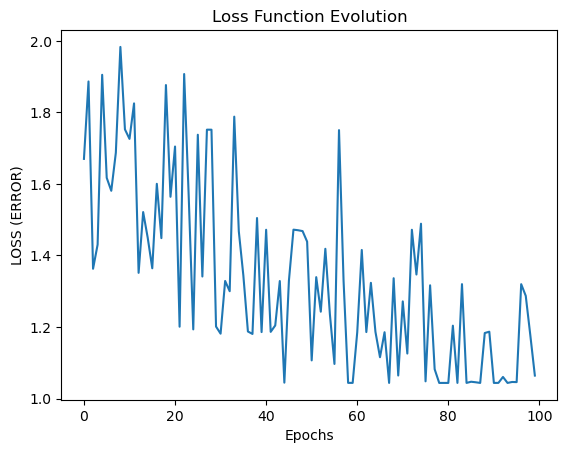

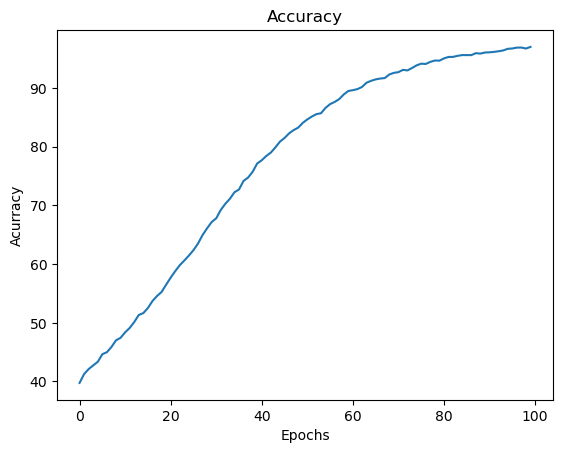

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 531/531 [00:06<00:00, 87.67it/s]



Accuracy:	 87.57 %


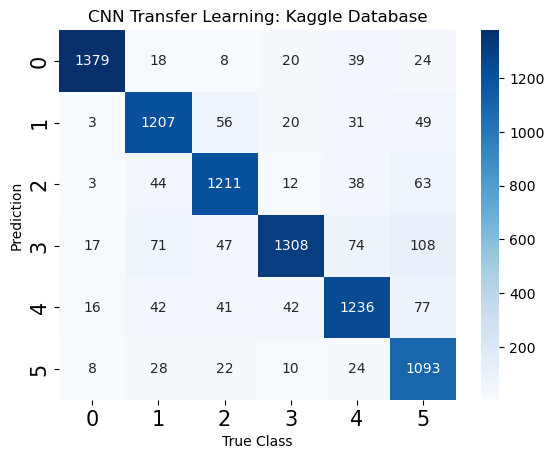

In [30]:
#model = load_Model(model, 'model.pt')
EPOCHS  = 100
NETWORK = 'PRETRAINED'
LEARNING_RATE = 0.15
DROPOUT = 0.40

optimizers = ['SGD']
print(optimizers)
for opt in optimizers:
    model = get_Model(NETWORK)
    optimizer = optim.SGD(model.parameters(), lr = LEARNING_RATE)
    if opt == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
    if opt == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr = LEARNING_RATE)
        
    model, loss_epoch, precision_epoch = train_Model(model)
    plot_Results(loss_epoch, precision_epoch)
    accuracy = eval_Model(model)
    name = ''.join(['FINAL_','KAGGLE','.txt'])
    with open(name, "w") as archivo:
        text = ''.join(['EPOCHS:', str(EPOCHS) ,  '\n',
                         'LEARNING RATE:', str(LEARNING_RATE), '\n',
                         'DROPOUT:', str(DROPOUT), '\n',
                         'ACCURACY:', str(accuracy), '\n'])
        archivo.write(text)